<a href="https://colab.research.google.com/github/kaivalyagnik/ml-practice-portfolio/blob/main/diabetes_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kaivalyagnik/ml-practice-portfolio/blob/d360e59f1e1dc7f703814cb2bacbf097e4b3c...)

You can also open this notebook in Google Colab to run it interactively.

#  Diabetes Prediction using Machine Learning
This notebook demonstrates a complete classification pipeline to predict whether a person is diabetic based on medical features.

**Goals:**
- Perform preprocessing on health-related data
- Build machine learning models (e.g., Logistic Regression, Random Forest)
- Evaluate models with appropriate metrics
- Visualize performance using ROC-AUC curves and classification reports

 Dataset: [Pima Indians Diabetes Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

##  1. Data Preprocessing
This section handles data loading, scaling, and train-test splitting.

We also explore null values, class distribution, and encoding if needed.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

try:
    import kagglehub
    path = kagglehub.dataset_download("akshaydattatraykhare/diabetes-dataset")
    data = pd.read_csv(path + "/diabetes.csv")
except Exception:
    data = pd.read_csv("diabetes.csv")

data.head()

100%|██████████| 8.91k/8.91k [00:00<00:00, 16.3MB/s]

Extracting files...


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


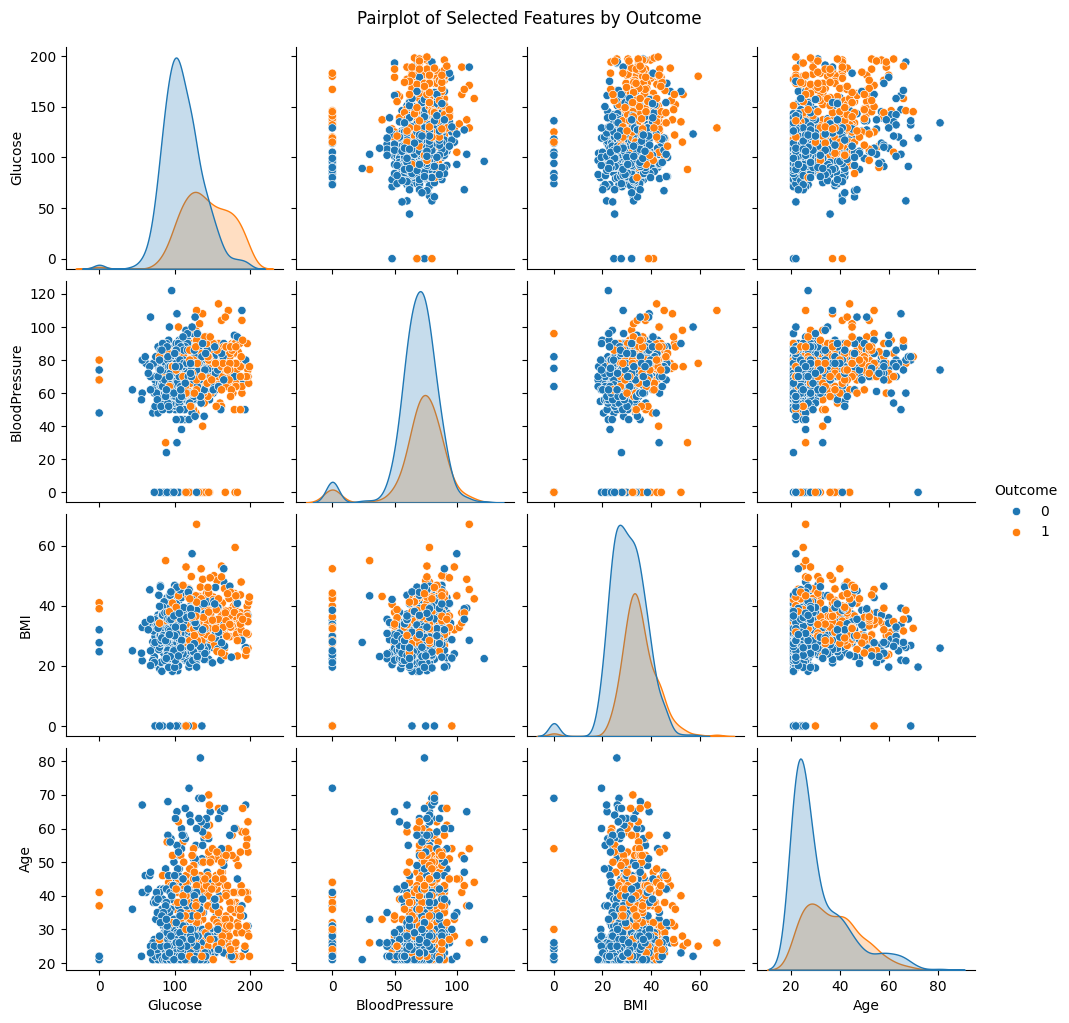

In [3]:
features = ['Glucose', 'BloodPressure', 'BMI', 'Age']
sb.pairplot(data, vars=features, hue='Outcome', diag_kind='kde')
plt.suptitle("Pairplot of Selected Features by Outcome", y=1.02)
plt.show()

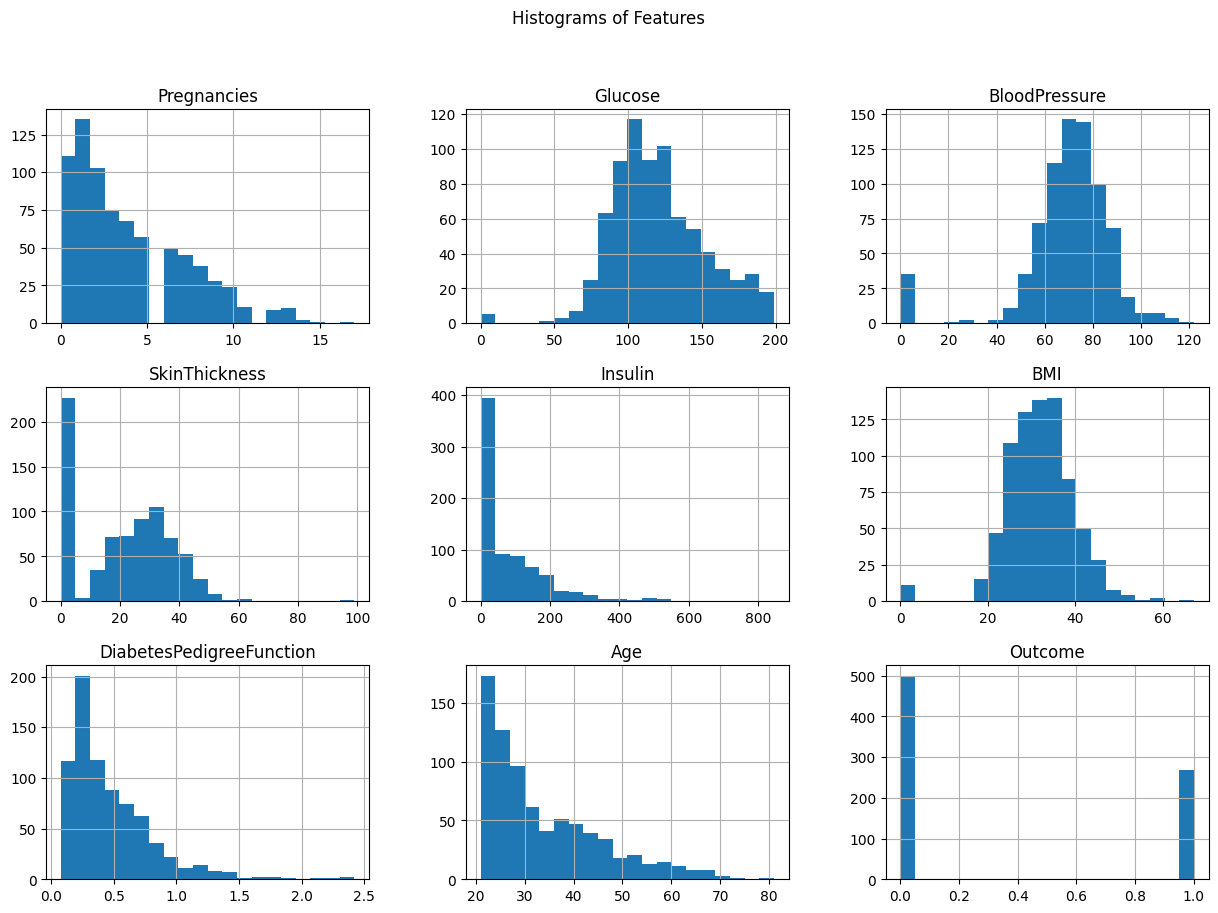

In [4]:
data.hist(bins=20, figsize=(15, 10))
plt.suptitle("Histograms of Features")
plt.show()

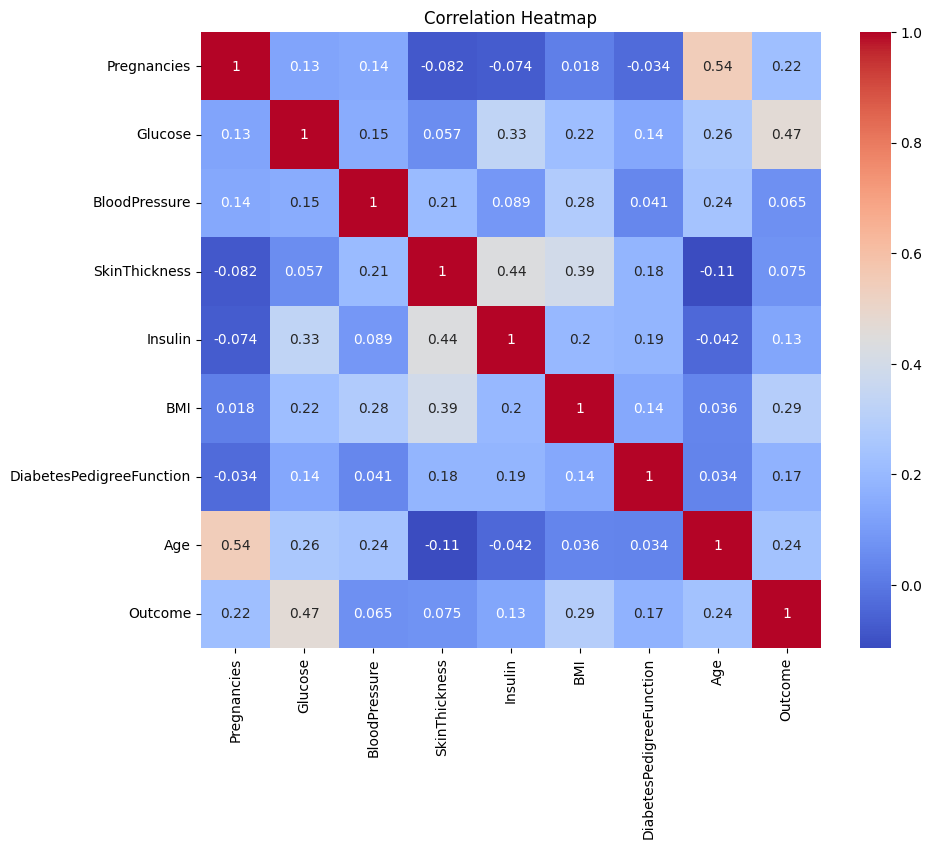

In [5]:
plt.figure(figsize=(10, 8))
sb.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

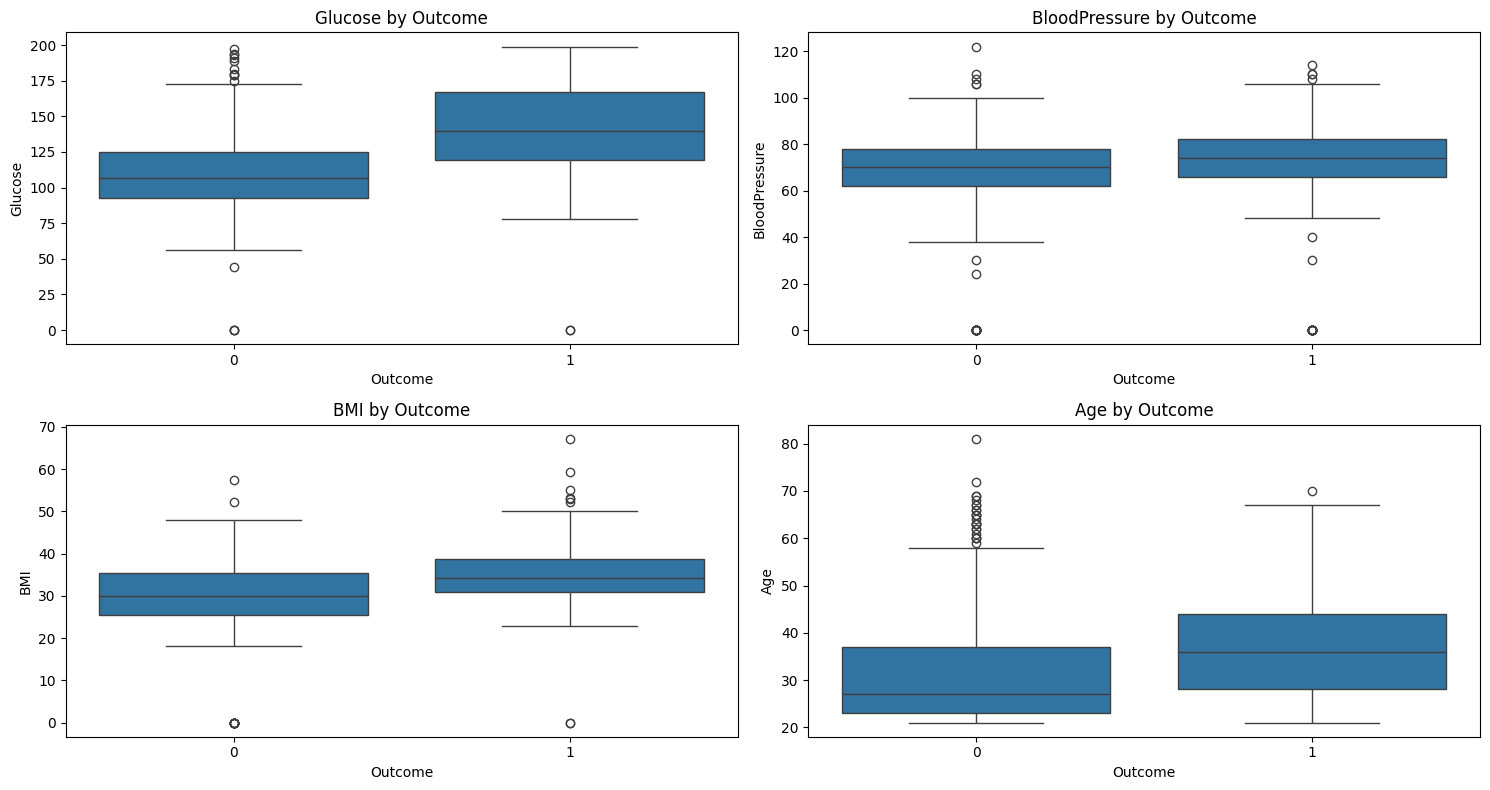

In [6]:
features = ['Glucose', 'BloodPressure', 'BMI', 'Age']
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sb.boxplot(x='Outcome', y=feature, data=data)
    plt.title(f"{feature} by Outcome")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

X = data.drop('Outcome', axis=1)
y = data['Outcome']
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
models = {
    "Logistic Regression (L2)": LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000),
    "Logistic Regression (L1)": LogisticRegression(C=1.0, penalty='l1', solver='liblinear', max_iter=1000),
    "ElasticNet (LogReg)": LogisticRegression(C=1.0, penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1.0, probability=True),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}
def evaluate_classifiers_with_roc(models, X_train, X_test, y_train, y_test, scale_models=None):
    if scale_models is None:
        scale_models = [name for name in models if "Logistic" in name or "SVM" in name or "ElasticNet" in name]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    plt.figure(figsize=(10, 8))
    for name, model in models.items():
        print(f"\n Evaluating: {name}")
        if name in scale_models:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            if hasattr(model, 'predict_proba'):
                y_scores = model.predict_proba(X_test_scaled)[:, 1]
            else:
                y_scores = model.decision_function(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if hasattr(model, 'predict_proba'):
                y_scores = model.predict_proba(X_test)[:, 1]
            else:
                y_scores = model.decision_function(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f" Accuracy: {acc:.4f}")
        print(" Classification Report:\n", classification_report(y_test, y_pred))
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(" ROC-AUC Curve for All Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Evaluating baseline models:

 Evaluating: Logistic Regression (L2)
 Accuracy: 0.7143
 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154


 Evaluating: Logistic Regression (L1)
 Accuracy: 0.7143
 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154


 Evaluating: ElasticNet (LogReg)
 Accuracy: 0.7143
 Classification Report:
               precision    recall  f1-score   support

           0       0.7

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:12:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Accuracy: 0.7792
 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83       100
           1       0.70      0.65      0.67        54

    accuracy                           0.78       154
   macro avg       0.76      0.75      0.75       154
weighted avg       0.78      0.78      0.78       154



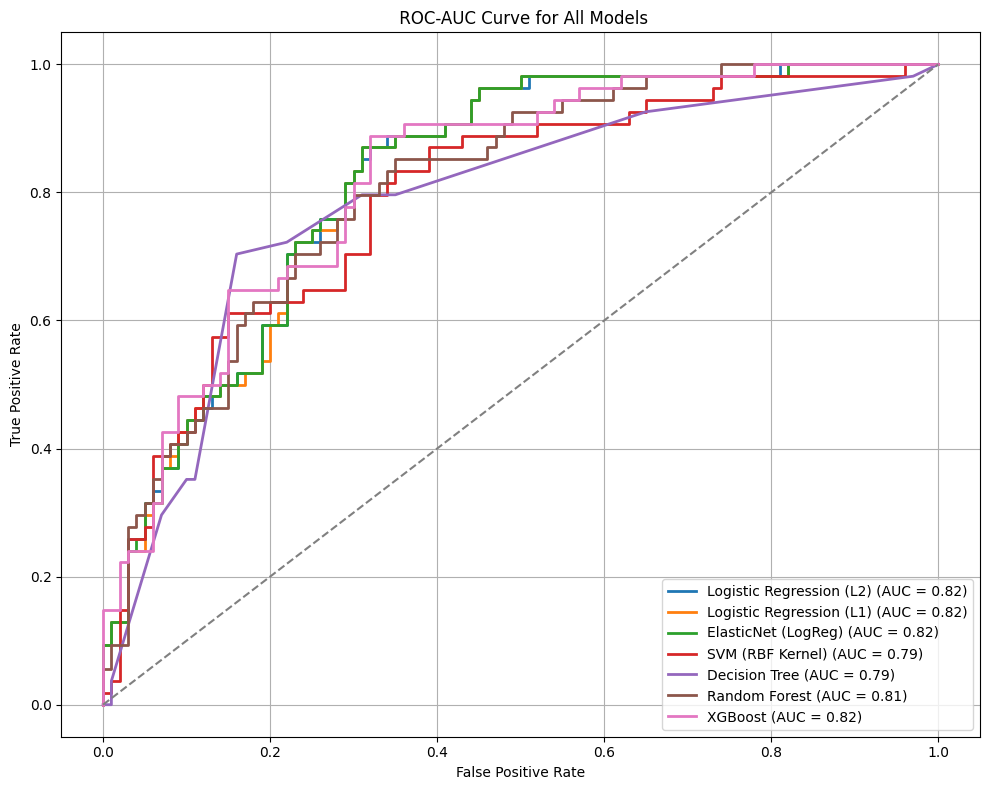


Evaluating hyperparameter-tuned models:

 Tuning and Evaluating: Logistic Regression (L2)
 Best Params: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Accuracy: 0.7143
 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       100
           1       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154


 Tuning and Evaluating: Logistic Regression (L1)
 Best Params: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1'}
Accuracy: 0.6948
 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.81      0.78       100
           1       0.58      0.48      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154


 Tu

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:13:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Accuracy: 0.7468
 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81       100
           1       0.67      0.56      0.61        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



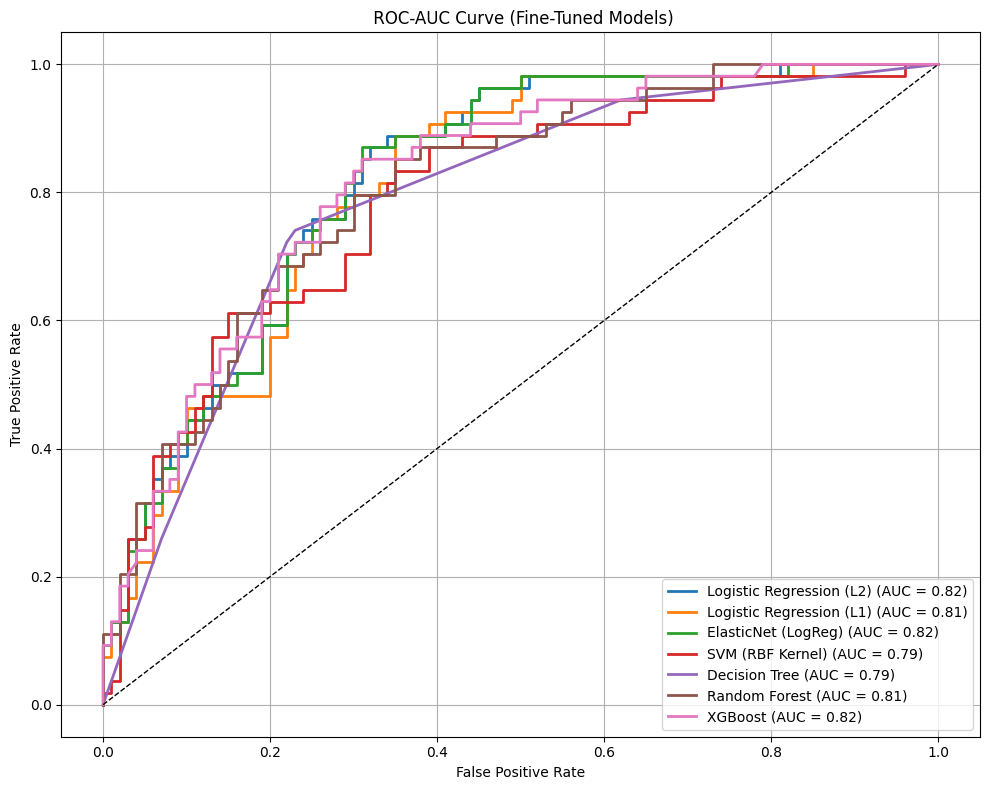

In [12]:
print('Evaluating baseline models:')
evaluate_classifiers_with_roc(models, X_train, X_test, y_train, y_test)

print('\nEvaluating hyperparameter-tuned models:')
evaluate_tuned_classifiers(model_grid, X_train, X_test, y_train, y_test)

In [11]:
model_grid = {
    "Logistic Regression (L2)": {
        "model": LogisticRegression(solver='liblinear', max_iter=1000),
        "params": {"C": [0.1, 1, 10], "penalty": ['l2'], "max_iter": [100, 500]}
    },
    "Logistic Regression (L1)": {
        "model": LogisticRegression(solver='liblinear', max_iter=1000),
        "params": {"C": [0.1, 1, 10], "penalty": ['l1'], "max_iter": [100, 500]}
    },
    "ElasticNet (LogReg)": {
        "model": LogisticRegression(solver='saga', max_iter=1000),
        "params": {"C": [0.1, 1], "penalty": ['elasticnet'], "l1_ratio": [0.5], "max_iter": [1000]}
    },
    "SVM (RBF Kernel)": {
        "model": SVC(probability=True),
        "params": {"C": [0.1, 1, 10], "gamma": ['scale', 'auto']}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {"max_depth": [3, 5, 7], "min_samples_split": [2, 5]}
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [100, 200], "max_depth": [5, 10], "min_samples_split": [2, 5]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {"n_estimators": [100, 200], "max_depth": [3, 5], "learning_rate": [0.1, 0.01]}
    }
}
def evaluate_tuned_classifiers(model_grid, X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scale_models = ["Logistic Regression", "ElasticNet", "SVM"]
    plt.figure(figsize=(10, 8))
    for name, config in model_grid.items():
        print(f"\n Tuning and Evaluating: {name}")
        model = config['model']
        params = config['params']
        scaled = any(keyword in name for keyword in scale_models)
        X_train_input = X_train_scaled if scaled else X_train
        X_test_input = X_test_scaled if scaled else X_test
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid = GridSearchCV(model, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train_input, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_input)
        acc = accuracy_score(y_test, y_pred)
        print(f" Best Params: {grid.best_params_}")
        print(f"Accuracy: {acc:.4f}")
        print(" Classification Report:\n", classification_report(y_test, y_pred))
        if hasattr(best_model, 'predict_proba'):
            y_scores = best_model.predict_proba(X_test_input)[:, 1]
        else:
            y_scores = best_model.decision_function(X_test_input)
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(" ROC-AUC Curve (Fine-Tuned Models)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()